In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/Colab Notebooks/07. Thesis

/content/drive/MyDrive/Colab Notebooks/07. Thesis


In [3]:
import DGM
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Disable eager execution to use TensorFlow 1.x functions
tf.compat.v1.disable_eager_execution()

# Check if GPU is available and set memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

def terminal_condition(y1, delta_a, delta_b, kappa_1, alpha_1, zeta, hat_y_1):
    ''' Compute the terminal condition for the PDE
    Args:
        y1: wealth
        delta_a: delta parameter a
        delta_b: delta parameter b
    '''
    return tf.exp(- (kappa_1 * alpha_1 / zeta) * (y1 - hat_y_1)**2)

def sampler(nSim_interior, nSim_terminal, t_low, t_high, y_low, y_high, delta_a_low, delta_a_high, delta_b_low, delta_b_high, T):
    ''' Sample time-space points from the function's domain; points are sampled
        uniformly on the interior of the domain and at the terminal time.

    Args:
        nSim_interior: number of space points in the interior of the function's domain to sample
        nSim_terminal: number of space points at terminal time to sample (terminal condition)
    '''
    # Sampler #1: domain interior
    t_interior = np.random.uniform(low=t_low, high=t_high, size=[nSim_interior, 1])
    y_interior = np.random.uniform(low=y_low, high=y_high, size=[nSim_interior, 1])
    delta_a_interior = np.random.uniform(low=delta_a_low, high=delta_a_high, size=[nSim_interior, 1])
    delta_b_interior = np.random.uniform(low=delta_b_low, high=delta_b_high, size=[nSim_interior, 1])

    # Sampler #2: terminal condition
    t_terminal = T * np.ones((nSim_terminal, 1))
    y_terminal = np.random.uniform(low=y_low, high=y_high, size=[nSim_terminal, 1])
    delta_a_terminal = np.random.uniform(low=delta_a_low, high=delta_a_high, size=[nSim_terminal, 1])
    delta_b_terminal = np.random.uniform(low=delta_b_low, high=delta_b_high, size=[nSim_terminal, 1])

    return t_interior, y_interior, delta_a_interior, delta_b_interior, t_terminal, y_terminal, delta_a_terminal, delta_b_terminal

def compute_loss(model, t_interior, y_interior, delta_a_interior, delta_b_interior, t_terminal, y_terminal, delta_a_terminal, delta_b_terminal, phi_1, alpha_1, kappa_1, zeta, hat_y_1, theta_2_a, mu_2_a, sigma_2_a, theta_2_b, mu_2_b, sigma_2_b, lambda_a, lambda_b, overline_y_1, underline_y_1):
    ''' Compute total loss for training.

    Args:
        model:      DGM model object
        t_interior: sampled time points in the interior of the function's domain
        y_interior: sampled space points in the interior of the function's domain
        delta_a_interior: sampled delta a points in the interior of the function's domain
        delta_b_interior: sampled delta b points in the interior of the function's domain
        t_terminal: sampled time points at terminal point (vector of terminal times)
        y_terminal: sampled space points at terminal time
        delta_a_terminal: sampled delta a points at terminal time
        delta_b_terminal: sampled delta b points at terminal time
    '''

    # Loss term #1: PDE
    # Compute function value and derivatives at current sampled points
    W = model((t_interior, y_interior, delta_a_interior, delta_b_interior))
    W_t = tf.gradients(W, t_interior)[0]
    W_y = tf.gradients(W, y_interior)[0]
    W_delta_a = tf.gradients(W, delta_a_interior)[0]
    W_delta_b = tf.gradients(W, delta_b_interior)[0]
    W_yy = tf.gradients(W_y, y_interior)[0]
    W_delta_aa = tf.gradients(W_delta_a, delta_a_interior)[0]
    W_delta_bb = tf.gradients(W_delta_b, delta_b_interior)[0]

    # Evaluate W at shifted y values
    W_y_plus_zeta = model((t_interior, y_interior + zeta, delta_a_interior, delta_b_interior))
    W_y_minus_zeta = model((t_interior, y_interior - zeta, delta_a_interior, delta_b_interior))

    # PDE residuals
    diff_W = (2 * W * W_t
              - (2 * phi_1 * kappa_1 / zeta) * (y_interior - hat_y_1)**2 * W**2
              + 2 * theta_2_a * (mu_2_a - delta_a_interior) * W * W_delta_a
              - (sigma_2_a)**2 * W_delta_a**2
              + (sigma_2_a)**2 * W * W_delta_aa
              + 2 * theta_2_b * (mu_2_b - delta_b_interior) * W * W_delta_b
              - (sigma_2_b)**2 * W_delta_b**2
              + (sigma_2_b)**2 * W * W_delta_bb
              + lambda_b * tf.exp(kappa_1 * delta_b_interior - 1) * W_y_plus_zeta**2 * tf.cast(y_interior + zeta <= overline_y_1, tf.float32)
              + lambda_a * tf.exp(kappa_1 * delta_a_interior - 1) * W_y_minus_zeta**2 * tf.cast(y_interior - zeta >= underline_y_1, tf.float32)
             )

    # Compute average L2-norm of differential operator
    L1 = tf.reduce_mean(tf.square(diff_W))

    # Loss term #2: terminal condition
    target_terminal = terminal_condition(y_terminal, delta_a_terminal, delta_b_terminal, kappa_1, alpha_1, zeta, hat_y_1)
    fitted_terminal = model((t_terminal, y_terminal, delta_a_terminal, delta_b_terminal))

    L3 = tf.reduce_mean(tf.square(fitted_terminal - target_terminal))

    return L1, L3

def solve_pde(phi_1=1e-5, kappa_1=10, zeta=1, theta_2_a=10, mu_2_a=0, sigma_2_a=0.02,
              theta_2_b=10, mu_2_b=0, sigma_2_b=0.02, lambda_a=1, lambda_b=1,
              alpha_1=1e-3, hat_y_1=0, overline_y_1=3, underline_y_1=-3,
              T=1, t_low=1e-10, t_high=1, y_low=-3, y_high=3,
              delta_a_low=-0.2, delta_a_high=0.2, delta_b_low=-0.2, delta_b_high=0.2,
              num_layers=4, nodes_per_layer=50, starting_learning_rate=0.001,
              sampling_stages=300, steps_per_sample=25, nSim_interior=1000, nSim_terminal=100,
              saveOutput=False, saveName='CustomPDE', saveFigure=False, figureName='CustomPDE'):

    # Initialize DGM model (last input: space dimension = 3)
    model = DGM.DGMNet(nodes_per_layer, num_layers, 3)

    # Tensor placeholders (_tnsr suffix indicates tensors)
    # Inputs (time, space domain interior, space domain at initial time)
    t_interior_tnsr = tf.compat.v1.placeholder(tf.float32, [None, 1])
    y_interior_tnsr = tf.compat.v1.placeholder(tf.float32, [None, 1])
    delta_a_interior_tnsr = tf.compat.v1.placeholder(tf.float32, [None, 1])
    delta_b_interior_tnsr = tf.compat.v1.placeholder(tf.float32, [None, 1])
    t_terminal_tnsr = tf.compat.v1.placeholder(tf.float32, [None, 1])
    y_terminal_tnsr = tf.compat.v1.placeholder(tf.float32, [None, 1])
    delta_a_terminal_tnsr = tf.compat.v1.placeholder(tf.float32, [None, 1])
    delta_b_terminal_tnsr = tf.compat.v1.placeholder(tf.float32, [None, 1])

    # Loss
    L1_tnsr, L3_tnsr = compute_loss(model, t_interior_tnsr, y_interior_tnsr, delta_a_interior_tnsr, delta_b_interior_tnsr, t_terminal_tnsr, y_terminal_tnsr, delta_a_terminal_tnsr, delta_b_terminal_tnsr, phi_1, alpha_1, kappa_1, zeta, hat_y_1, theta_2_a, mu_2_a, sigma_2_a, theta_2_b, mu_2_b, sigma_2_b, lambda_a, lambda_b, overline_y_1, underline_y_1)
    loss_tnsr = L1_tnsr + L3_tnsr

    # Value function
    W = model((t_interior_tnsr, y_interior_tnsr, delta_a_interior_tnsr, delta_b_interior_tnsr))

    # Set optimizer
    global_step = tf.compat.v1.Variable(0, trainable=False)
    learning_rate = tf.compat.v1.train.exponential_decay(starting_learning_rate, global_step, 100000, 0.96, staircase=True)
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss_tnsr)

    # Initialize variables
    init_op = tf.compat.v1.global_variables_initializer()

    # Open session
    sess = tf.compat.v1.Session()
    sess.run(init_op)

    # Train network
    # Initialize loss per training
    loss_list = []

    # For each sampling stage
    for i in range(sampling_stages):
        # Sample uniformly from the required regions
        t_interior, y_interior, delta_a_interior, delta_b_interior, t_terminal, y_terminal, delta_a_terminal, delta_b_terminal = sampler(nSim_interior, nSim_terminal, t_low, t_high, y_low, y_high, delta_a_low, delta_a_high, delta_b_low, delta_b_high, T)

        # For a given sample, take the required number of SGD steps
        for _ in range(steps_per_sample):
            loss_val, L1, L3, _ = sess.run([loss_tnsr, L1_tnsr, L3_tnsr, optimizer],
                                    feed_dict = {t_interior_tnsr: t_interior, y_interior_tnsr: y_interior, delta_a_interior_tnsr: delta_a_interior, delta_b_interior_tnsr: delta_b_interior, t_terminal_tnsr: t_terminal, y_terminal_tnsr: y_terminal, delta_a_terminal_tnsr: delta_a_terminal, delta_b_terminal_tnsr: delta_b_terminal})
            loss_list.append(loss_val)

        print(loss_val, L1, L3, i)

    # Save output
    if saveOutput:
        saver = tf.compat.v1.train.Saver()
        saver.save(sess, './SavedNets/' + saveName)

    return model, sess, t_interior_tnsr, y_interior_tnsr, delta_a_interior_tnsr, delta_b_interior_tnsr, W

1 Physical GPUs, 1 Logical GPUs


In [4]:
# Example usage
model, sess_1, t_interior_tnsr, y_interior_tnsr, delta_a_interior_tnsr, delta_b_interior_tnsr, W = solve_pde()

# Example of extracting w for specific values
t_val = np.array([[0.5]])
y_val = np.array([[0.0]])
delta_a_val = np.array([[0.0]])
delta_b_val = np.array([[0.0]])

w_val = sess_1.run(W, feed_dict={t_interior_tnsr: t_val, y_interior_tnsr: y_val, delta_a_interior_tnsr: delta_a_val, delta_b_interior_tnsr: delta_b_val})
print("w(t, y, delta_a, delta_b) =", w_val)


0.46067688 0.20139018 0.2592867 0
0.25445443 0.10066422 0.15379022 1
0.15283276 0.0632586 0.08957416 2
0.08897012 0.039477497 0.04949262 3
0.071337655 0.039856162 0.031481493 4
0.056896616 0.036417782 0.020478833 5
0.05370739 0.035081342 0.018626051 6
0.04629444 0.034541536 0.011752903 7
0.04031589 0.02963705 0.01067884 8
0.036971074 0.027793601 0.009177472 9
0.03576639 0.027474875 0.008291515 10
0.031161528 0.023869658 0.0072918697 11
0.031045461 0.023781627 0.007263833 12
0.029097425 0.022586059 0.0065113665 13
0.027107902 0.021381255 0.0057266476 14
0.026565788 0.020287307 0.0062784813 15
0.022946777 0.017515209 0.0054315687 16
0.022313928 0.017246485 0.0050674435 17
0.021859258 0.01647061 0.0053886487 18
0.021177549 0.015935898 0.005241652 19
0.020753175 0.015510074 0.005243101 20
0.018156074 0.013775995 0.0043800785 21
0.017862009 0.014110607 0.0037514018 22
0.016775629 0.012437064 0.0043385644 23
0.017001309 0.01308733 0.003913978 24
0.01519351 0.011841839 0.0033516705 25
0.01484

In [5]:
# Sample test points
T=1
t_test = np.array([[T/2]])  # Test time point at halfway through the terminal time
y_test = np.array([[0.0]])  # Test wealth point at 0.0
delta_a_test = np.array([[0.0]])  # Test delta_a at 0.0
delta_b_test = np.array([[0.0]])  # Test delta_b at 0.0

# Convert test points to the expected shape (batch size, feature size)
t_test = t_test.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
delta_a_test = delta_a_test.reshape(-1, 1)
delta_b_test = delta_b_test.reshape(-1, 1)

# Evaluate the model at test points
w_test = sess_1.run(W, feed_dict={
    t_interior_tnsr: t_test,
    y_interior_tnsr: y_test,
    delta_a_interior_tnsr: delta_a_test,
    delta_b_interior_tnsr: delta_b_test
})

print("w(t_test, y_test, delta_a_test, delta_b_test) =", w_test)

w(t_test, y_test, delta_a_test, delta_b_test) = [[1.1879612]]


In [6]:
#%% Define the h, H, delta functions

def h(t, y, zeta, kappa_1, delta_a, delta_b, sess):
    """Compute h based on w"""
    # Sample test points
    t_test = np.array([[t]])
    y_test = np.array([[y]])
    delta_a_test = np.array([[delta_a]])
    delta_b_test = np.array([[delta_b]])

    # Evaluate the model at test points
    w = sess.run(W, feed_dict={t_interior_tnsr: t_test, y_interior_tnsr: y_test, delta_a_interior_tnsr: delta_a_test, delta_b_interior_tnsr: delta_b_test})
    return (zeta / kappa_1) * np.log(w)  # Use numpy log here for the final evaluation

def H(t, x, y, z, zeta, kappa_1, delta_a, delta_b, sess):
    """Compute H based on h and w"""
    h_val = h(t, y, zeta, kappa_1, delta_a, delta_b, sess)
    return x + y * z + h_val

def delta_b_star(t, y, zeta, kappa_1, delta_a, delta_b, sess):
    """Compute delta_b_star based on h"""
    h_1st = h(t, y, zeta, kappa_1, delta_a, delta_b, sess)
    h_2nd = h(t, y + zeta, zeta, kappa_1, delta_a, delta_b, sess)
    return (1 / (2 * kappa_1)) + (h_1st / zeta) - (h_2nd / zeta)

def delta_a_star(t, y, zeta, kappa_1, delta_a, delta_b, sess):
    """Compute delta_a_star based on h"""
    h_1st = h(t, y, zeta, kappa_1, delta_a, delta_b, sess)
    h_2nd = h(t, y - zeta, zeta, kappa_1, delta_a, delta_b, sess)
    return (1 / (2 * kappa_1)) + (h_1st / zeta) - (h_2nd / zeta)

def optimal_controls(t, y, zeta, delta_a, delta_b, sess):
    delta_a_star_x=delta_a_star(t, y, zeta, kappa_1, delta_a, delta_b, sess)
    delta_b_star_x=delta_b_star(t, y, zeta, kappa_1, delta_a, delta_b, sess)
    return delta_a_star_x,delta_b_star_x

In [7]:
#%% Test the model output

# Sample test points
kappa_1=10
zeta=1
t_test = 0.8  # Single value for t
y_test = 1  # Single value for y
delta_a_test = 0.1  # Single value for delta_a
delta_b_test = 0.1  # Single value for delta_b
z_test = 1  # Value for z
x_test = 1  # Value for x
zeta = 1  # Value for zeta

h_test = h(t_test, y_test, zeta, kappa_1, delta_a_test, delta_b_test,sess_1)
H_test = H(t_test, x_test, y_test, z_test, zeta, kappa_1, delta_a_test, delta_b_test,sess_1)
delta_b_star_test = delta_b_star(t_test, y_test, zeta, kappa_1, delta_a_test, delta_b_test,sess_1)
delta_a_star_test = delta_a_star(t_test, y_test, zeta, kappa_1, delta_a_test, delta_b_test,sess_1)

print("h(t_test, y_test, delta_a_test, delta_b_test) =", h_test)
print("H(t_test, y_test, delta_a_test, delta_b_test) =", H_test)
print("delta_b_star(t_test, y_test, zeta, delta_a_test, delta_b_test) =", delta_b_star_test)
print("delta_a_star(t_test, y_test, zeta, delta_a_test, delta_b_test) =", delta_a_star_test)


h(t_test, y_test, delta_a_test, delta_b_test) = [[0.00945254]]
H(t_test, y_test, delta_a_test, delta_b_test) = [[2.0094526]]
delta_b_star(t_test, y_test, zeta, delta_a_test, delta_b_test) = [[0.05712797]]
delta_a_star(t_test, y_test, zeta, delta_a_test, delta_b_test) = [[0.04888416]]


In [38]:
# Function to simulate an OU process
def simulate_ou_process(theta, mu, sigma, dt, T, initial_value):
    n_steps = int(T / dt)
    delta = np.zeros(n_steps)
    delta[0] = initial_value

    for t in range(1, n_steps):
        delta[t] = delta[t-1] + theta * (mu - delta[t-1]) * dt + sigma * np.sqrt(dt) * np.random.normal()
    return delta

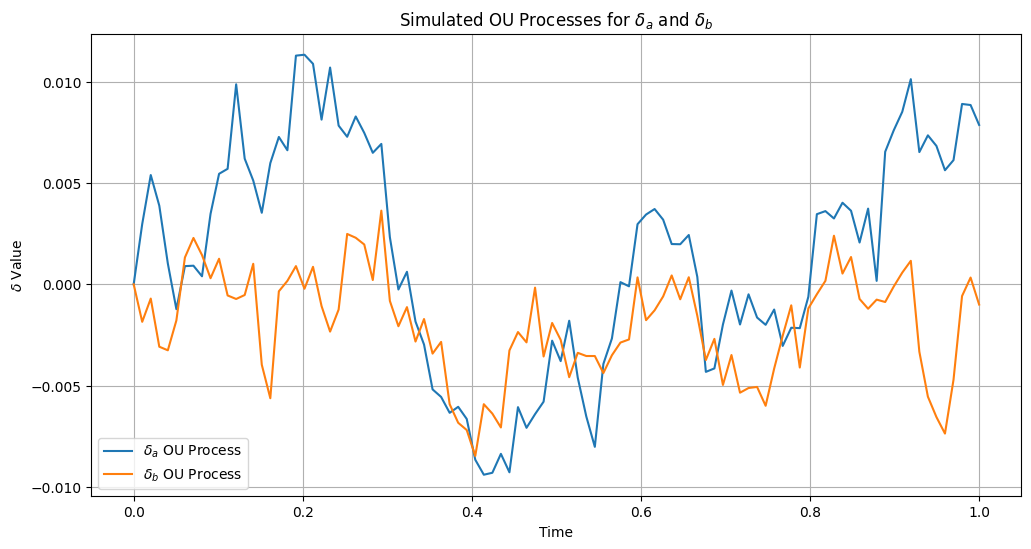

In [13]:
# Parameters for the OU process
theta_a = 10  # Mean reversion rate for delta_a
mu_a = 0  # Mean level for delta_a
sigma_a = 0.02  # Volatility for delta_a

theta_b = 10  # Mean reversion rate for delta_b
mu_b = 0  # Mean level for delta_b
sigma_b = 0.02  # Volatility for delta_b



# Simulation parameters
dt = 0.01  # Time step
T = 1  # Total time
n_points = int(T / dt)  # Number of points

# Simulate the processes
initial_value_a = 0
initial_value_b = 0
delta_a_simulation = simulate_ou_process(theta_a, mu_a, sigma_a, dt, T, initial_value_a)
delta_b_simulation = simulate_ou_process(theta_b, mu_b, sigma_b, dt, T, initial_value_b)

# Plot the simulated processes
time_points = np.linspace(0, T, n_points)
plt.figure(figsize=(12, 6))

plt.plot(time_points, delta_a_simulation, label=r'$\delta_a$ OU Process')
plt.plot(time_points, delta_b_simulation, label=r'$\delta_b$ OU Process')

plt.xlabel('Time')
plt.ylabel(r'$\delta$ Value')
plt.title('Simulated OU Processes for $\delta_a$ and $\delta_b$')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
time_steps = 100  # Number of time steps to evaluate
t_grid = np.linspace(0, T, time_steps)
y_test_range=[-3,-2,-1,1,2,3]
# Storing results for each time point (x-coordinate) and y (y-coordinate)
delta_b_star_1 = np.zeros((len(y_test_range),len(t_grid)))
delta_a_star_1 = np.zeros((len(y_test_range),len(t_grid)))
zeta=1
# Compute W(t) for each time point
for i,y_test in enumerate(y_test_range):
    for j, t in enumerate(t_grid):
        delta_a_star_1[i,j], delta_b_star_1[i,j] = optimal_controls(t, y_test, zeta, delta_a_simulation[j], delta_b_simulation[j],sess_1)

<ipython-input-6-c5f423aa900e>:13: RuntimeWarning: invalid value encountered in log
  return (zeta / kappa_1) * np.log(w)  # Use numpy log here for the final evaluation
<ipython-input-9-5352409c712e>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta_a_star_1[i,j], delta_b_star_1[i,j] = optimal_controls(t, y_test, zeta, delta_a_simulation[j], delta_b_simulation[j],sess_1)


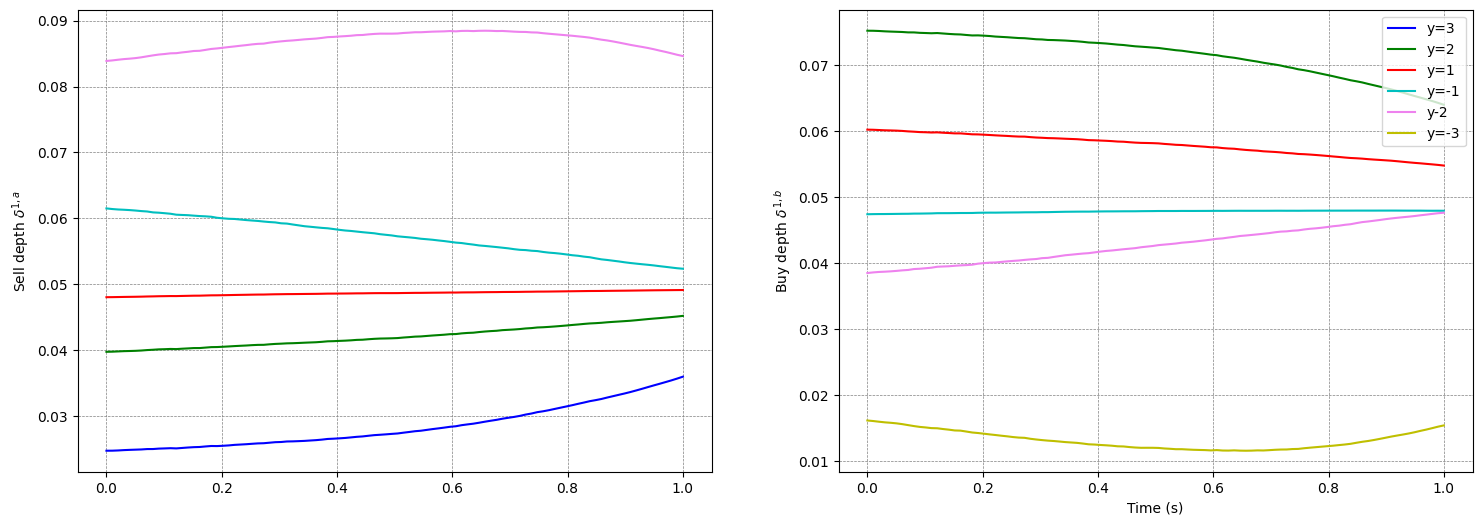

In [11]:
plt.figure(figsize=(18,6))


plt.subplot(1,2,1)
plt.plot(t_grid,delta_a_star_1[5,:],'b',label='$y=3$')
plt.plot(t_grid,delta_a_star_1[4,:],'g',label='$y=2$')
plt.plot(t_grid,delta_a_star_1[3,:],'r',label='$y=1$')
plt.plot(t_grid,delta_a_star_1[2,:],'c',label='$y=-1$')
plt.plot(t_grid,delta_a_star_1[1,:],'violet',label='$y=-2$')
plt.plot(t_grid,delta_a_star_1[0,:],'y',label='$y=-3$')
plt.ylabel(r'Sell depth $\delta^{1,a}$')  # Using raw string for LaTeX compatibility
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02])  # Set specific y-axis ticks


plt.subplot(1,2,2)
plt.plot(t_grid,delta_b_star_1[5,:],'b',label='y=3')
plt.plot(t_grid,delta_b_star_1[4,:],'g',label='y=2')
plt.plot(t_grid,delta_b_star_1[3,:],'r',label='y=1')
plt.plot(t_grid,delta_b_star_1[2,:],'c',label='y=-1')
plt.plot(t_grid,delta_b_star_1[1,:],'violet',label='y-2')
plt.plot(t_grid,delta_b_star_1[0,:],'y',label='y=-3')
plt.xlabel('Time (s)')
plt.ylabel(r'Buy depth $\delta^{1,b}$')  # Using raw string for LaTeX compatibility
plt.legend()
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02]);  # Set specific y-axis ticks


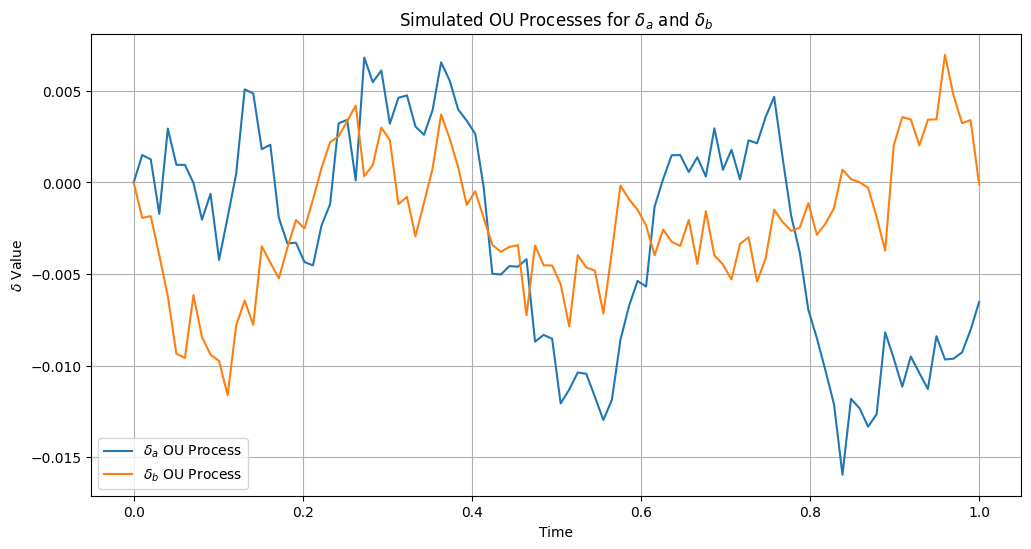

In [21]:
# Parameters for the OU process
theta_a = 2  # Mean reversion rate for delta_a
mu_a = 0  # Mean level for delta_a
sigma_a = 0.02  # Volatility for delta_a

theta_b = 2  # Mean reversion rate for delta_b
mu_b = 0  # Mean level for delta_b
sigma_b = 0.02  # Volatility for delta_b



# Simulation parameters
dt = 0.01  # Time step
T = 1  # Total time
n_points = int(T / dt)  # Number of points

# Simulate the processes
initial_value_a = 0
initial_value_b = 0
delta_a_simulation_2 = simulate_ou_process(theta_a, mu_a, sigma_a, dt, T, initial_value_a)
delta_b_simulation_2 = simulate_ou_process(theta_b, mu_b, sigma_b, dt, T, initial_value_b)

# Plot the simulated processes
time_points = np.linspace(0, T, n_points)
plt.figure(figsize=(12, 6))

plt.plot(time_points, delta_a_simulation, label=r'$\delta_a$ OU Process')
plt.plot(time_points, delta_b_simulation, label=r'$\delta_b$ OU Process')

plt.xlabel('Time')
plt.ylabel(r'$\delta$ Value')
plt.title('Simulated OU Processes for $\delta_a$ and $\delta_b$')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
model, sess_2, t_interior_tnsr, y_interior_tnsr, delta_a_interior_tnsr, delta_b_interior_tnsr, W = solve_pde(theta_2_a=2, mu_2_a=0, sigma_2_a=0.02, theta_2_b=2, mu_2_b=0, sigma_2_b=0.02)

0.31119558 0.11941115 0.19178443 0
0.25730458 0.08731937 0.16998522 1
0.25268182 0.08899644 0.16368538 2
0.21720892 0.08032004 0.13688889 3
0.16583085 0.06831436 0.09751649 4
0.09109147 0.05661618 0.034475286 5
0.055767067 0.03733318 0.018433888 6
0.03762496 0.026638377 0.0109865805 7
0.029467639 0.01986314 0.009604498 8
0.026450008 0.018316096 0.008133912 9
0.028664865 0.021729363 0.0069355015 10
0.019916285 0.01365832 0.006257966 11
0.019586448 0.0134791685 0.00610728 12
0.015765734 0.011008806 0.004756928 13
0.01616002 0.010171465 0.0059885555 14
0.016179048 0.010132744 0.0060463035 15
0.014646031 0.010128686 0.0045173448 16
0.013957823 0.009216618 0.004741205 17
0.013365664 0.008414365 0.0049512982 18
0.014763793 0.010177539 0.004586254 19
0.014540391 0.010930588 0.0036098035 20
0.010928277 0.007152662 0.0037756143 21
0.010398762 0.006439082 0.003959681 22
0.0114177205 0.0076449625 0.0037727582 23
0.012971954 0.008366902 0.004605052 24
0.009868832 0.006575622 0.0032932102 25
0.0155

In [23]:
time_steps = 100  # Number of time steps to evaluate
t_grid = np.linspace(0, T, time_steps)
y_test_range=[-3,-2,-1,1,2,3]
# Storing results for each time point (x-coordinate) and y (y-coordinate)
delta_b_star_2 = np.zeros((len(y_test_range),len(t_grid)))
delta_a_star_2 = np.zeros((len(y_test_range),len(t_grid)))
zeta=1
# Compute W(t) for each time point
for i,y_test in enumerate(y_test_range):
    for j, t in enumerate(t_grid):
        delta_a_star_2[i,j], delta_b_star_2[i,j] = optimal_controls(t, y_test, zeta, delta_a_simulation_2[j], delta_b_simulation_2[j],sess_2)

<ipython-input-6-c5f423aa900e>:13: RuntimeWarning: invalid value encountered in log
  return (zeta / kappa_1) * np.log(w)  # Use numpy log here for the final evaluation
<ipython-input-23-b8cc233cbc1e>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta_a_star_2[i,j], delta_b_star_2[i,j] = optimal_controls(t, y_test, zeta, delta_a_simulation_2[j], delta_b_simulation_2[j],sess_2)


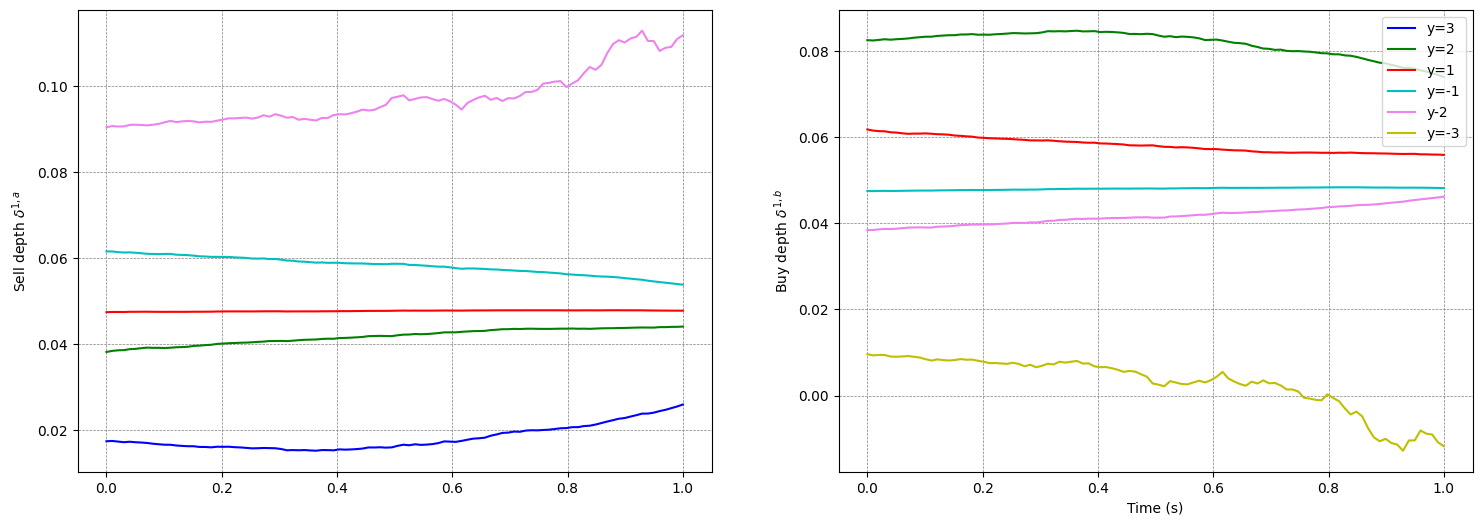

In [24]:
plt.figure(figsize=(18,6))


plt.subplot(1,2,1)
plt.plot(t_grid,delta_a_star_2[5,:],'b',label='$y=3$')
plt.plot(t_grid,delta_a_star_2[4,:],'g',label='$y=2$')
plt.plot(t_grid,delta_a_star_2[3,:],'r',label='$y=1$')
plt.plot(t_grid,delta_a_star_2[2,:],'c',label='$y=-1$')
plt.plot(t_grid,delta_a_star_2[1,:],'violet',label='$y=-2$')
plt.plot(t_grid,delta_a_star_2[0,:],'y',label='$y=-3$')
plt.ylabel(r'Sell depth $\delta^{1,a}$')  # Using raw string for LaTeX compatibility
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02])  # Set specific y-axis ticks


plt.subplot(1,2,2)
plt.plot(t_grid,delta_b_star_2[5,:],'b',label='y=3')
plt.plot(t_grid,delta_b_star_2[4,:],'g',label='y=2')
plt.plot(t_grid,delta_b_star_2[3,:],'r',label='y=1')
plt.plot(t_grid,delta_b_star_2[2,:],'c',label='y=-1')
plt.plot(t_grid,delta_b_star_2[1,:],'violet',label='y-2')
plt.plot(t_grid,delta_b_star_2[0,:],'y',label='y=-3')
plt.xlabel('Time (s)')
plt.ylabel(r'Buy depth $\delta^{1,b}$')  # Using raw string for LaTeX compatibility
plt.legend()
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02]);  # Set specific y-axis ticks


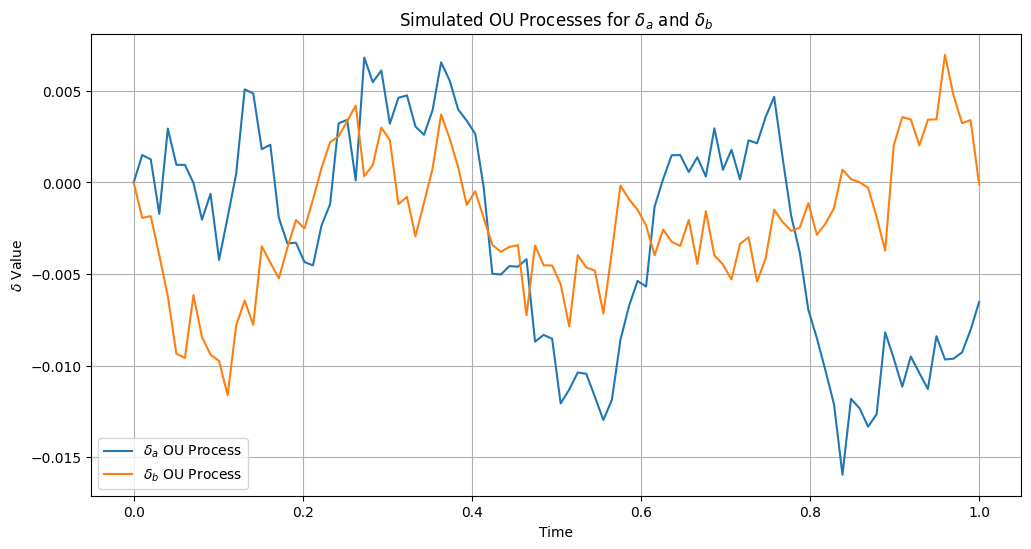

In [27]:
# Parameters for the OU process
theta_a = 10  # Mean reversion rate for delta_a
mu_a = 0  # Mean level for delta_a
sigma_a = 0.2  # Volatility for delta_a

theta_b = 10  # Mean reversion rate for delta_b
mu_b = 0  # Mean level for delta_b
sigma_b = 0.2  # Volatility for delta_b



# Simulation parameters
dt = 0.01  # Time step
T = 1  # Total time
n_points = int(T / dt)  # Number of points

# Simulate the processes
initial_value_a = 0
initial_value_b = 0
delta_a_simulation_3 = simulate_ou_process(theta_a, mu_a, sigma_a, dt, T, initial_value_a)
delta_b_simulation_3 = simulate_ou_process(theta_b, mu_b, sigma_b, dt, T, initial_value_b)

# Plot the simulated processes
time_points = np.linspace(0, T, n_points)
plt.figure(figsize=(12, 6))

plt.plot(time_points, delta_a_simulation, label=r'$\delta_a$ OU Process')
plt.plot(time_points, delta_b_simulation, label=r'$\delta_b$ OU Process')

plt.xlabel('Time')
plt.ylabel(r'$\delta$ Value')
plt.title('Simulated OU Processes for $\delta_a$ and $\delta_b$')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
model, sess_3, t_interior_tnsr, y_interior_tnsr, delta_a_interior_tnsr, delta_b_interior_tnsr, W = solve_pde(theta_2_a=10, mu_2_a=0, sigma_2_a=0.2, theta_2_b=10, mu_2_b=0, sigma_2_b=0.2)

0.83149207 0.5324431 0.29904896 0
0.43981782 0.20183498 0.23798284 1
0.3418218 0.12693071 0.21489108 2
0.26355022 0.1006352 0.16291502 3
0.22062582 0.10017969 0.12044614 4
0.19979063 0.0939131 0.105877526 5
0.11009893 0.072939545 0.03715938 6
0.057427216 0.04326084 0.0141663775 7
0.04642479 0.035564397 0.010860396 8
0.039532498 0.03138922 0.008143277 9
0.03481152 0.027809387 0.007002133 10
0.028723631 0.022335507 0.006388125 11
0.029418718 0.023168178 0.0062505393 12
0.028795835 0.021819469 0.006976366 13
0.02699927 0.020962987 0.006036283 14
0.02415606 0.01932939 0.004826671 15
0.020928044 0.016315585 0.004612458 16
0.020632245 0.015851093 0.004781152 17
0.01812527 0.013667371 0.004457899 18
0.018914375 0.01404508 0.0048692957 19
0.017514123 0.013064331 0.0044497917 20
0.015772006 0.011933379 0.0038386262 21
0.01566448 0.011836335 0.0038281465 22
0.01591267 0.011769709 0.004142961 23
0.015219156 0.011483757 0.0037353989 24
0.0119299125 0.008858906 0.0030710066 25
0.011768503 0.0088263

In [29]:
time_steps = 100  # Number of time steps to evaluate
t_grid = np.linspace(0, T, time_steps)
y_test_range=[-3,-2,-1,1,2,3]
# Storing results for each time point (x-coordinate) and y (y-coordinate)
delta_b_star_3 = np.zeros((len(y_test_range),len(t_grid)))
delta_a_star_3 = np.zeros((len(y_test_range),len(t_grid)))
zeta=1
# Compute W(t) for each time point
for i,y_test in enumerate(y_test_range):
    for j, t in enumerate(t_grid):
        delta_a_star_3[i,j], delta_b_star_3[i,j] = optimal_controls(t, y_test, zeta, delta_a_simulation_3[j], delta_b_simulation_3[j],sess_3)

<ipython-input-6-c5f423aa900e>:13: RuntimeWarning: invalid value encountered in log
  return (zeta / kappa_1) * np.log(w)  # Use numpy log here for the final evaluation
<ipython-input-29-3fb9b4327e7f>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta_a_star_3[i,j], delta_b_star_3[i,j] = optimal_controls(t, y_test, zeta, delta_a_simulation_3[j], delta_b_simulation_3[j],sess_3)


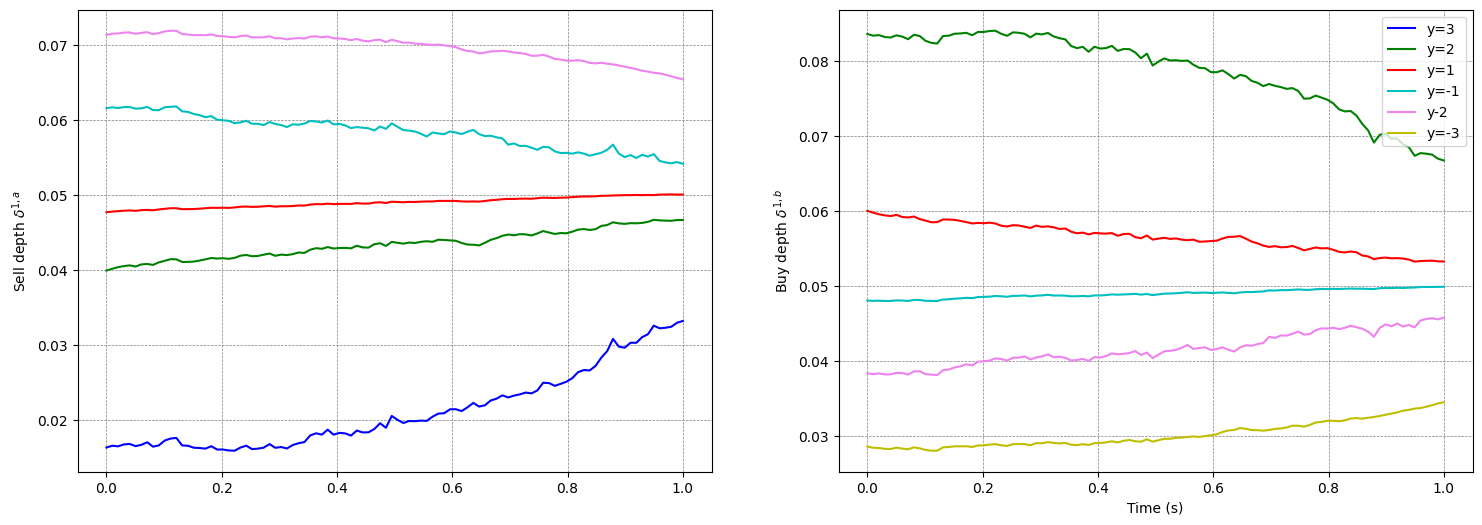

In [30]:
plt.figure(figsize=(18,6))


plt.subplot(1,2,1)
plt.plot(t_grid,delta_a_star_3[5,:],'b',label='$y=3$')
plt.plot(t_grid,delta_a_star_3[4,:],'g',label='$y=2$')
plt.plot(t_grid,delta_a_star_3[3,:],'r',label='$y=1$')
plt.plot(t_grid,delta_a_star_3[2,:],'c',label='$y=-1$')
plt.plot(t_grid,delta_a_star_3[1,:],'violet',label='$y=-2$')
plt.plot(t_grid,delta_a_star_3[0,:],'y',label='$y=-3$')
plt.ylabel(r'Sell depth $\delta^{1,a}$')  # Using raw string for LaTeX compatibility
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02])  # Set specific y-axis ticks


plt.subplot(1,2,2)
plt.plot(t_grid,delta_b_star_3[5,:],'b',label='y=3')
plt.plot(t_grid,delta_b_star_3[4,:],'g',label='y=2')
plt.plot(t_grid,delta_b_star_3[3,:],'r',label='y=1')
plt.plot(t_grid,delta_b_star_3[2,:],'c',label='y=-1')
plt.plot(t_grid,delta_b_star_3[1,:],'violet',label='y-2')
plt.plot(t_grid,delta_b_star_3[0,:],'y',label='y=-3')
plt.xlabel('Time (s)')
plt.ylabel(r'Buy depth $\delta^{1,b}$')  # Using raw string for LaTeX compatibility
plt.legend()
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02]);  # Set specific y-axis ticks


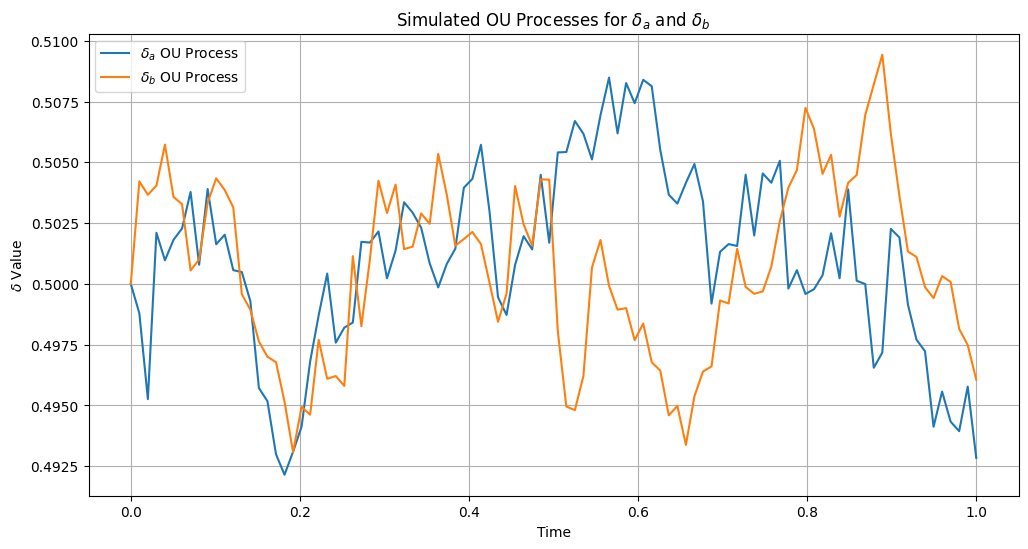

In [39]:
# Parameters for the OU process
theta_a = 10  # Mean reversion rate for delta_a
mu_a = 0.5 # Mean level for delta_a
sigma_a = 0.02  # Volatility for delta_a

theta_b = 10  # Mean reversion rate for delta_b
mu_b = 0.5  # Mean level for delta_b
sigma_b = 0.02  # Volatility for delta_b


# Simulation parameters
dt = 0.01  # Time step
T = 1  # Total time
n_points = int(T / dt)  # Number of points

# Simulate the processes
initial_value_a = 0.5
initial_value_b = 0.5
delta_a_simulation_4 = simulate_ou_process(theta_a, mu_a, sigma_a, dt, T, initial_value_a)
delta_b_simulation_4 = simulate_ou_process(theta_b, mu_b, sigma_b, dt, T, initial_value_b)

# Plot the simulated processes
time_points = np.linspace(0, T, n_points)
plt.figure(figsize=(12, 6))

plt.plot(time_points, delta_a_simulation_4, label=r'$\delta_a$ OU Process')
plt.plot(time_points, delta_b_simulation_4, label=r'$\delta_b$ OU Process')

plt.xlabel('Time')
plt.ylabel(r'$\delta$ Value')
plt.title('Simulated OU Processes for $\delta_a$ and $\delta_b$')
plt.legend()
plt.grid(True)
plt.show()

In [40]:
model, sess_4, t_interior_tnsr, y_interior_tnsr, delta_a_interior_tnsr, delta_b_interior_tnsr, W = solve_pde(theta_2_a=10, mu_2_a=0.5, sigma_2_a=0.02, theta_2_b=10, mu_2_b=0.5, sigma_2_b=0.02)

1.7137733 0.7691599 0.9446133 0
0.47058105 0.20686278 0.26371828 1
0.22546409 0.13560812 0.08985597 2
0.14349449 0.09953323 0.043961253 3
0.12443641 0.09316367 0.03127274 4
0.09924834 0.07764198 0.021606363 5
0.07818846 0.06357943 0.014609027 6
0.065922804 0.05408847 0.0118343355 7
0.066333115 0.055501364 0.010831755 8
0.059457175 0.04984809 0.009609085 9
0.057377413 0.0471862 0.010191215 10
0.046044506 0.039528117 0.00651639 11
0.03775263 0.032284316 0.0054683117 12
0.037777968 0.032226603 0.0055513643 13
0.033975814 0.028634192 0.005341621 14
0.03203904 0.027528973 0.0045100646 15
0.030991387 0.026613416 0.0043779714 16
0.02568942 0.020852335 0.004837085 17
0.022732336 0.019374877 0.0033574598 18
0.02400877 0.020191984 0.0038167855 19
0.025060592 0.02020086 0.004859732 20
0.020961363 0.018025735 0.0029356265 21
0.019629605 0.016015386 0.0036142198 22
0.020129694 0.017119434 0.0030102595 23
0.018256316 0.014794018 0.0034622976 24
0.016845774 0.013987262 0.002858513 25
0.014568909 0.01

In [41]:
time_steps = 100  # Number of time steps to evaluate
t_grid = np.linspace(0, T, time_steps)
y_test_range=[-3,-2,-1,1,2,3]
# Storing results for each time point (x-coordinate) and y (y-coordinate)
delta_b_star_4 = np.zeros((len(y_test_range),len(t_grid)))
delta_a_star_4 = np.zeros((len(y_test_range),len(t_grid)))
zeta=1
# Compute W(t) for each time point
for i,y_test in enumerate(y_test_range):
    for j, t in enumerate(t_grid):
        delta_a_star_4[i,j], delta_b_star_4[i,j] = optimal_controls(t, y_test, zeta, delta_a_simulation_4[j], delta_b_simulation_4[j],sess_4)

<ipython-input-6-c5f423aa900e>:13: RuntimeWarning: invalid value encountered in log
  return (zeta / kappa_1) * np.log(w)  # Use numpy log here for the final evaluation
<ipython-input-41-9c0b176885d7>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta_a_star_4[i,j], delta_b_star_4[i,j] = optimal_controls(t, y_test, zeta, delta_a_simulation_4[j], delta_b_simulation_4[j],sess_4)


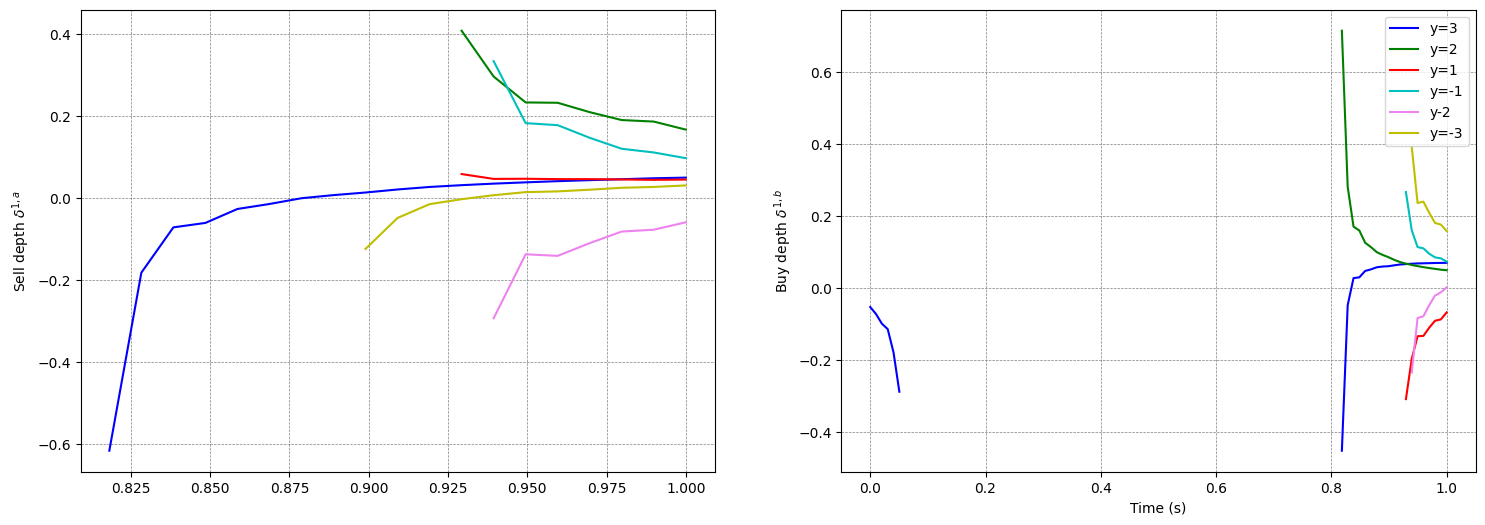

In [42]:
plt.figure(figsize=(18,6))


plt.subplot(1,2,1)
plt.plot(t_grid,delta_a_star_4[5,:],'b',label='$y=3$')
plt.plot(t_grid,delta_a_star_4[4,:],'g',label='$y=2$')
plt.plot(t_grid,delta_a_star_4[3,:],'r',label='$y=1$')
plt.plot(t_grid,delta_a_star_4[2,:],'c',label='$y=-1$')
plt.plot(t_grid,delta_a_star_4[1,:],'violet',label='$y=-2$')
plt.plot(t_grid,delta_a_star_4[0,:],'y',label='$y=-3$')
plt.ylabel(r'Sell depth $\delta^{1,a}$')  # Using raw string for LaTeX compatibility
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02])  # Set specific y-axis ticks


plt.subplot(1,2,2)
plt.plot(t_grid,delta_b_star_4[5,:],'b',label='y=3')
plt.plot(t_grid,delta_b_star_4[4,:],'g',label='y=2')
plt.plot(t_grid,delta_b_star_4[3,:],'r',label='y=1')
plt.plot(t_grid,delta_b_star_4[2,:],'c',label='y=-1')
plt.plot(t_grid,delta_b_star_4[1,:],'violet',label='y-2')
plt.plot(t_grid,delta_b_star_4[0,:],'y',label='y=-3')
plt.xlabel('Time (s)')
plt.ylabel(r'Buy depth $\delta^{1,b}$')  # Using raw string for LaTeX compatibility
plt.legend()
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02]);  # Set specific y-axis ticks


In [44]:
# Function to simulate correlated OU processes
def simulate_correlated_ou_processes(theta_a, mu_a, sigma_a, theta_b, mu_b, sigma_b, dt, T, initial_value_a, initial_value_b, rho):
    n_steps = int(T / dt)
    delta_a = np.zeros(n_steps)
    delta_b = np.zeros(n_steps)
    delta_a[0] = initial_value_a
    delta_b[0] = initial_value_b

    # Generate independent standard normal random variables
    Z1 = np.random.normal(size=n_steps)
    Z2 = np.random.normal(size=n_steps)

    # Create correlated random variables using Cholesky decomposition
    L = np.array([[1, 0], [rho, np.sqrt(1 - rho**2)]])
    correlated_randomness = L @ np.array([Z1, Z2])

    for t in range(1, n_steps):
        delta_a[t] = delta_a[t-1] + theta_a * (mu_a - delta_a[t-1]) * dt + sigma_a * np.sqrt(dt) * correlated_randomness[0, t-1]
        delta_b[t] = delta_b[t-1] + theta_b * (mu_b - delta_b[t-1]) * dt + sigma_b * np.sqrt(dt) * correlated_randomness[1, t-1]
        # Clip the values to stay within bounds
        delta_a[t] = np.clip(delta_a[t], mu_a - 0.1, mu_a + 0.1)
        delta_b[t] = np.clip(delta_b[t], mu_b - 0.1, mu_b + 0.1)

    return delta_a, delta_b



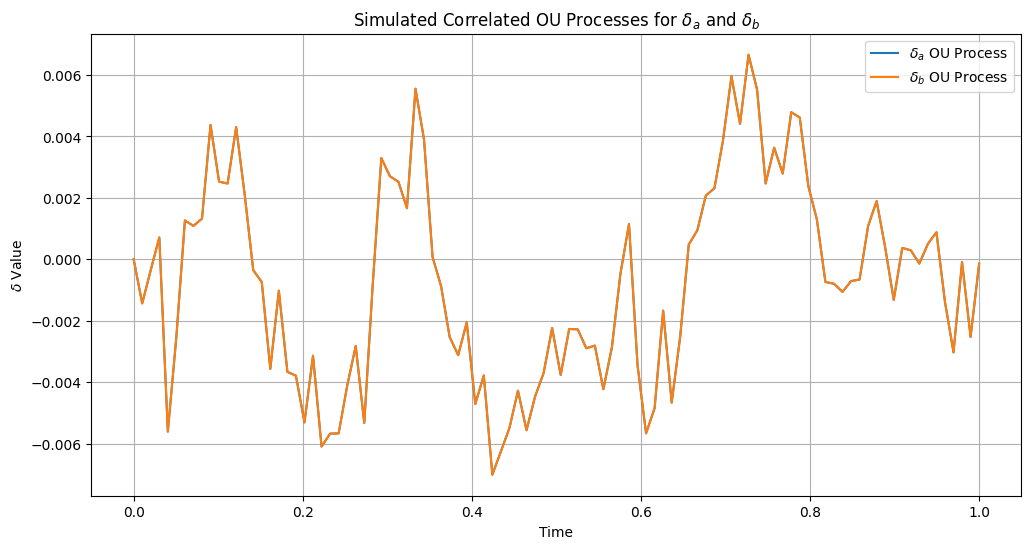

In [47]:
# Parameters for the OU process
theta_a = 10  # Mean reversion rate for delta_a
mu_a = 0  # Mean level for delta_a
sigma_a = 0.02  # Volatility for delta_a

theta_b = 10  # Mean reversion rate for delta_b
mu_b = 0  # Mean level for delta_b
sigma_b = 0.02  # Volatility for delta_b

# Correlation coefficient
rho = 1

# Simulation parameters
dt = 0.01  # Time step
T = 1  # Total time
n_points = int(T / dt)  # Number of points

# Simulate the processes
initial_value_a = 0
initial_value_b = 0
delta_a_simulation_5, delta_b_simulation_5 = simulate_correlated_ou_processes(theta_a, mu_a, sigma_a, theta_b, mu_b, sigma_b, dt, T, initial_value_a, initial_value_b, rho)

# Plot the simulated processes
time_points = np.linspace(0, T, n_points)
plt.figure(figsize=(12, 6))

plt.plot(time_points, delta_a_simulation_5, label=r'$\delta_a$ OU Process')
plt.plot(time_points, delta_b_simulation_5, label=r'$\delta_b$ OU Process')

plt.xlabel('Time')
plt.ylabel(r'$\delta$ Value')
plt.title('Simulated Correlated OU Processes for $\delta_a$ and $\delta_b$')
plt.legend()
plt.grid(True)
plt.show()


In [46]:
model, sess_5, t_interior_tnsr, y_interior_tnsr, delta_a_interior_tnsr, delta_b_interior_tnsr, W = solve_pde(theta_2_a=10, mu_2_a=0, sigma_2_a=0.02, theta_2_b=10, mu_2_b=0, sigma_2_b=0.02)

0.36873844 0.17084439 0.19789405 0
0.21370706 0.10882849 0.104878575 1
0.14614996 0.09120311 0.054946862 2
0.10191854 0.06792603 0.033992514 3
0.05069607 0.04012304 0.01057303 4
0.03680255 0.02866484 0.008137708 5
0.03241627 0.02525308 0.007163191 6
0.022960607 0.018223748 0.004736859 7
0.023166688 0.01771372 0.0054529677 8
0.017159056 0.0134450905 0.0037139647 9
0.013848284 0.011047407 0.0028008772 10
0.016248845 0.012147217 0.004101628 11
0.023458168 0.019536637 0.0039215307 12
0.015178675 0.012037897 0.0031407783 13
0.014203191 0.01048093 0.0037222612 14
0.01158448 0.008230027 0.0033544537 15
0.013693316 0.010245179 0.0034481368 16
0.011800925 0.008807261 0.0029936647 17
0.011691353 0.008079953 0.0036114007 18
0.015352735 0.010901487 0.004451248 19
0.010474196 0.007299388 0.0031748074 20
0.013516456 0.0100215655 0.0034948906 21
0.010342645 0.007396677 0.0029459682 22
0.018162886 0.015848024 0.0023148614 23
0.012527151 0.009398184 0.0031289668 24
0.011246633 0.008334919 0.0029117144 

In [48]:
time_steps = 100  # Number of time steps to evaluate
t_grid = np.linspace(0, T, time_steps)
y_test_range=[-3,-2,-1,1,2,3]
# Storing results for each time point (x-coordinate) and y (y-coordinate)
delta_b_star_5 = np.zeros((len(y_test_range),len(t_grid)))
delta_a_star_5 = np.zeros((len(y_test_range),len(t_grid)))
zeta=1
# Compute W(t) for each time point
for i,y_test in enumerate(y_test_range):
    for j, t in enumerate(t_grid):
        delta_a_star_5[i,j], delta_b_star_5[i,j] = optimal_controls(t, y_test, zeta, delta_a_simulation_5[j], delta_b_simulation_5[j],sess_5)

<ipython-input-48-b98e83fcc616>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta_a_star_5[i,j], delta_b_star_5[i,j] = optimal_controls(t, y_test, zeta, delta_a_simulation_5[j], delta_b_simulation_5[j],sess_5)
<ipython-input-6-c5f423aa900e>:13: RuntimeWarning: invalid value encountered in log
  return (zeta / kappa_1) * np.log(w)  # Use numpy log here for the final evaluation


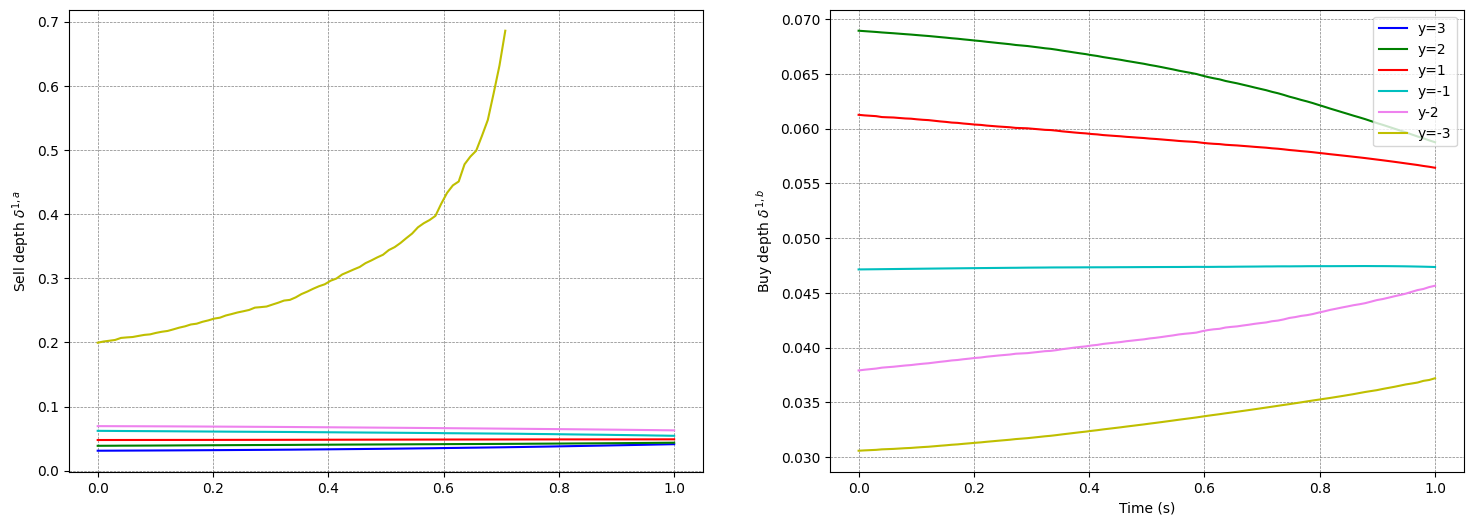

In [49]:
plt.figure(figsize=(18,6))


plt.subplot(1,2,1)
plt.plot(t_grid,delta_a_star_5[5,:],'b',label='$y=3$')
plt.plot(t_grid,delta_a_star_5[4,:],'g',label='$y=2$')
plt.plot(t_grid,delta_a_star_5[3,:],'r',label='$y=1$')
plt.plot(t_grid,delta_a_star_5[2,:],'c',label='$y=-1$')
plt.plot(t_grid,delta_a_star_5[1,:],'violet',label='$y=-2$')
plt.plot(t_grid,delta_a_star_5[0,:],'y',label='$y=-3$')
plt.ylabel(r'Sell depth $\delta^{1,a}$')  # Using raw string for LaTeX compatibility
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02])  # Set specific y-axis ticks


plt.subplot(1,2,2)
plt.plot(t_grid,delta_b_star_5[5,:],'b',label='y=3')
plt.plot(t_grid,delta_b_star_5[4,:],'g',label='y=2')
plt.plot(t_grid,delta_b_star_5[3,:],'r',label='y=1')
plt.plot(t_grid,delta_b_star_5[2,:],'c',label='y=-1')
plt.plot(t_grid,delta_b_star_5[1,:],'violet',label='y-2')
plt.plot(t_grid,delta_b_star_5[0,:],'y',label='y=-3')
plt.xlabel('Time (s)')
plt.ylabel(r'Buy depth $\delta^{1,b}$')  # Using raw string for LaTeX compatibility
plt.legend()
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02]);  # Set specific y-axis ticks


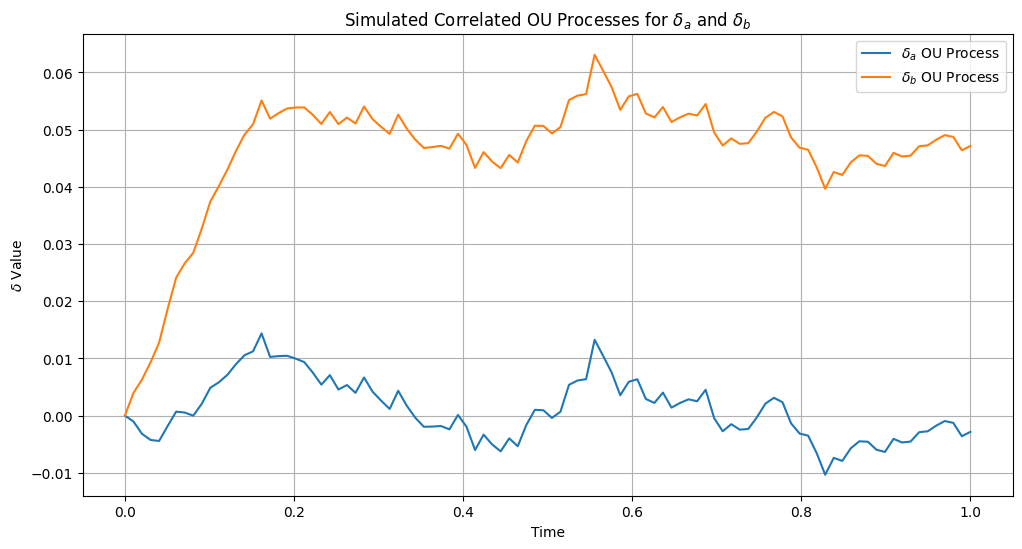

In [53]:
# Parameters for the OU process
theta_a = 10  # Mean reversion rate for delta_a
mu_a = 0  # Mean level for delta_a
sigma_a = 0.02  # Volatility for delta_a

theta_b = 10  # Mean reversion rate for delta_b
mu_b = 0.05  # Mean level for delta_b
sigma_b = 0.02  # Volatility for delta_b

# Correlation coefficient
rho = 1

# Simulation parameters
dt = 0.01  # Time step
T = 1  # Total time
n_points = int(T / dt)  # Number of points

# Simulate the processes
initial_value_a = 0
initial_value_b = 0
delta_a_simulation_6, delta_b_simulation_6 = simulate_correlated_ou_processes(theta_a, mu_a, sigma_a, theta_b, mu_b, sigma_b, dt, T, initial_value_a, initial_value_b, rho)

# Plot the simulated processes
time_points = np.linspace(0, T, n_points)
plt.figure(figsize=(12, 6))

plt.plot(time_points, delta_a_simulation_6, label=r'$\delta_a$ OU Process')
plt.plot(time_points, delta_b_simulation_6, label=r'$\delta_b$ OU Process')

plt.xlabel('Time')
plt.ylabel(r'$\delta$ Value')
plt.title('Simulated Correlated OU Processes for $\delta_a$ and $\delta_b$')
plt.legend()
plt.grid(True)
plt.show()


In [51]:
model, sess_6, t_interior_tnsr, y_interior_tnsr, delta_a_interior_tnsr, delta_b_interior_tnsr, W = solve_pde(theta_2_a=10, mu_2_a=0, sigma_2_a=0.02, theta_2_b=10, mu_2_b=0.05, sigma_2_b=0.02)

0.7627033 0.3688142 0.39388907 0
0.48867577 0.18386734 0.30480844 1
0.37268662 0.1386269 0.23405974 2
0.33355257 0.1242391 0.20931347 3
0.28116727 0.10607245 0.17509481 4
0.28462967 0.10340229 0.18122739 5
0.2511114 0.099865176 0.15124622 6
0.21657911 0.09336974 0.12320938 7
0.17880341 0.088730805 0.09007261 8
0.11191769 0.07848894 0.033428747 9
0.0704675 0.051063646 0.019403853 10
0.053222872 0.041965906 0.011256966 11
0.051316306 0.040007822 0.011308483 12
0.044799738 0.035152603 0.009647135 13
0.041203156 0.032708377 0.008494778 14
0.03417073 0.027572827 0.0065979 15
0.03230285 0.025902715 0.006400134 16
0.029960506 0.02370743 0.006253074 17
0.029022051 0.023097547 0.005924504 18
0.030045986 0.023477945 0.0065680416 19
0.024621397 0.019916352 0.0047050463 20
0.023046125 0.018616965 0.00442916 21
0.021989603 0.017907526 0.0040820767 22
0.024153117 0.019829582 0.0043235347 23
0.018748667 0.015022792 0.0037258754 24
0.01885213 0.01554985 0.00330228 25
0.018777534 0.014630907 0.00414662

In [54]:
time_steps = 100  # Number of time steps to evaluate
t_grid = np.linspace(0, T, time_steps)
y_test_range=[-3,-2,-1,1,2,3]
# Storing results for each time point (x-coordinate) and y (y-coordinate)
delta_b_star_6 = np.zeros((len(y_test_range),len(t_grid)))
delta_a_star_6 = np.zeros((len(y_test_range),len(t_grid)))
zeta=1
# Compute W(t) for each time point
for i,y_test in enumerate(y_test_range):
    for j, t in enumerate(t_grid):
        delta_a_star_6[i,j], delta_b_star_6[i,j] = optimal_controls(t, y_test, zeta, delta_a_simulation_6[j], delta_b_simulation_6[j],sess_6)

<ipython-input-6-c5f423aa900e>:13: RuntimeWarning: invalid value encountered in log
  return (zeta / kappa_1) * np.log(w)  # Use numpy log here for the final evaluation
<ipython-input-54-8b3489921bee>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta_a_star_6[i,j], delta_b_star_6[i,j] = optimal_controls(t, y_test, zeta, delta_a_simulation_6[j], delta_b_simulation_6[j],sess_6)


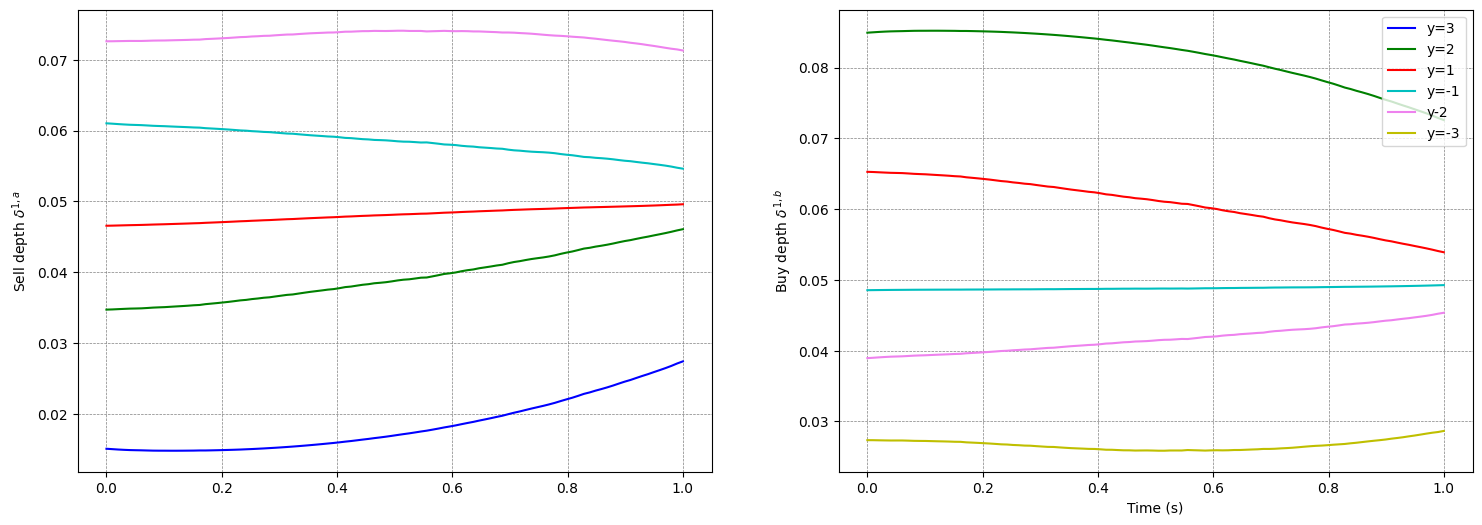

In [55]:
plt.figure(figsize=(18,6))


plt.subplot(1,2,1)
plt.plot(t_grid,delta_a_star_6[5,:],'b',label='$y=3$')
plt.plot(t_grid,delta_a_star_6[4,:],'g',label='$y=2$')
plt.plot(t_grid,delta_a_star_6[3,:],'r',label='$y=1$')
plt.plot(t_grid,delta_a_star_6[2,:],'c',label='$y=-1$')
plt.plot(t_grid,delta_a_star_6[1,:],'violet',label='$y=-2$')
plt.plot(t_grid,delta_a_star_6[0,:],'y',label='$y=-3$')
plt.ylabel(r'Sell depth $\delta^{1,a}$')  # Using raw string for LaTeX compatibility
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02])  # Set specific y-axis ticks


plt.subplot(1,2,2)
plt.plot(t_grid,delta_b_star_6[5,:],'b',label='y=3')
plt.plot(t_grid,delta_b_star_6[4,:],'g',label='y=2')
plt.plot(t_grid,delta_b_star_6[3,:],'r',label='y=1')
plt.plot(t_grid,delta_b_star_6[2,:],'c',label='y=-1')
plt.plot(t_grid,delta_b_star_6[1,:],'violet',label='y-2')
plt.plot(t_grid,delta_b_star_6[0,:],'y',label='y=-3')
plt.xlabel('Time (s)')
plt.ylabel(r'Buy depth $\delta^{1,b}$')  # Using raw string for LaTeX compatibility
plt.legend()
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02]);  # Set specific y-axis ticks

In [ ]:
phi11 = np.linspace(10**(-1),10**(-5),5) # No inventory penalty
t=t_grid[-1]
delta_a_2=delta_a_simulation[-1];
delta_b_2=delta_b_simulation[-1];
y_test_range=[-3,-2,-1,1,2,3]
# Storing results for each time point (x-coordinate) and y (y-coordinate)
delta_b_star_2 = np.zeros((len(y_test_range),len(phi11)))
delta_a_star_2 = np.zeros((len(y_test_range),len(phi11)))
# Compute W(t) for each time point
for j, phi in enumerate(phi11):
  model, sess_2, t_interior_tnsr, y_interior_tnsr, delta_a_interior_tnsr, delta_b_interior_tnsr, W = solve_pde(phi_1=phi)
  for i,y_test in enumerate(y_test_range):
    delta_b_star_2[i,j], delta_a_star_2[i,j] = optimal_controls(t, y_test, zeta, delta_a_2, delta_b_2,sess_2)

3.192204 2.9745126 0.21769136 0
1.0868795 0.5671882 0.5196912 1
0.70498717 0.37100425 0.3339829 2
0.5554577 0.27990347 0.27555427 3
0.52680135 0.2577091 0.26909223 4
0.48654515 0.22245435 0.26409078 5
0.44963253 0.19044788 0.25918466 6
0.4013544 0.17386636 0.22748804 7
0.39350766 0.18329746 0.2102102 8
0.3565622 0.15092523 0.20563696 9
0.3257199 0.13856207 0.18715781 10
0.3378117 0.14470255 0.19310915 11
0.30949134 0.11638396 0.19310738 12
0.28849512 0.117595576 0.17089954 13
0.30672047 0.11934931 0.18737116 14
0.26819402 0.101070166 0.16712385 15
0.26884168 0.10838712 0.16045457 16
0.27573386 0.11059495 0.16513892 17
0.24527766 0.097247735 0.14802992 18
0.2169369 0.08771995 0.12921695 19
0.25652564 0.103548996 0.15297665 20
0.2223986 0.085128054 0.13727054 21
0.19946223 0.0778655 0.121596746 22
0.21694936 0.08852206 0.1284273 23
0.2064578 0.0836108 0.12284698 24
0.20691156 0.084281236 0.12263033 25
0.1810377 0.07535246 0.105685234 26
0.16991219 0.07111609 0.0987961 27
0.16971584 0.074

<ipython-input-27-ecf919a6bdac>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta_b_star_2[i,j], delta_a_star_2[i,j] = optimal_controls(t, y_test, zeta, delta_a_2, delta_b_2,sess_2)


15.210945 15.031192 0.17975318 0
1.7991729 1.4037238 0.39544904 1
1.3513349 0.945783 0.4055519 2
1.0765228 0.7446328 0.33189002 3
0.8521003 0.53312385 0.31897646 4
0.6960051 0.43849686 0.25750828 5
0.60766256 0.39356327 0.21409929 6
0.54692155 0.35373423 0.19318733 7
0.5132712 0.3189086 0.19436264 8
0.47045493 0.29480556 0.17564937 9
0.39851654 0.24255309 0.15596344 10
0.43833488 0.28389114 0.15444374 11
0.38768846 0.25893122 0.12875725 12
0.37558803 0.24961151 0.12597652 13
0.3509946 0.22674155 0.12425303 14
0.34307584 0.22487001 0.11820583 15
0.32549575 0.22153702 0.10395873 16
0.30271837 0.19484311 0.10787526 17
0.29430234 0.1964181 0.097884245 18
0.2887474 0.18959424 0.09915317 19
0.29373515 0.18882261 0.10491255 20
0.29331574 0.17896613 0.1143496 21
0.2679006 0.16157469 0.106325895 22
0.265527 0.16104768 0.10447931 23
0.2514099 0.16011193 0.09129796 24
0.23946792 0.1539198 0.08554812 25
0.21707806 0.13813975 0.078938305 26
0.22676674 0.14016078 0.08660596 27
0.23114325 0.1412316 0

<ipython-input-21-a58d69f8ac15>:13: RuntimeWarning: invalid value encountered in log
  return (zeta / kappa_1) * np.log(w)  # Use numpy log here for the final evaluation


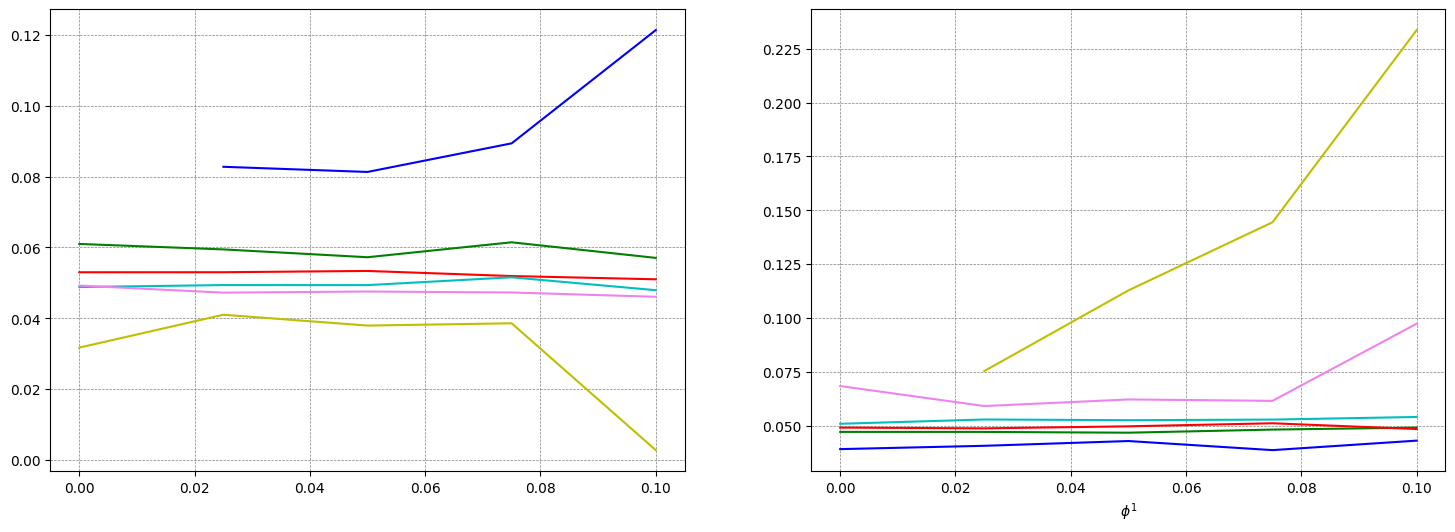

In [ ]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plt.plot(phi11,delta_a_star_2[5,:],'b',label='y=3')
plt.plot(phi11,delta_a_star_2[4,:],'g',label='y=2')
plt.plot(phi11,delta_a_star_2[3,:],'r',label='y=1')
plt.plot(phi11,delta_a_star_2[2,:],'c',label='y=-1')
plt.plot(phi11,delta_a_star_2[1,:],'violet',label='y=-2')
plt.plot(phi11,delta_a_star_2[0,:],'y',label='y=-3')
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02])  # Set specific y-axis ticks


plt.subplot(1,2,2)
plt.plot(phi11,delta_b_star_2[5,:],'b',label='y=3')
plt.plot(phi11,delta_b_star_2[4,:],'g',label='y=2')
plt.plot(phi11,delta_b_star_2[3,:],'r',label='y=1')
plt.plot(phi11,delta_b_star_2[2,:],'c',label='y=-1')
plt.plot(phi11,delta_b_star_2[1,:],'violet',label='y-2')
plt.plot(phi11,delta_b_star_2[0,:],'y',label='y=-3')
plt.xlabel('$\\phi^1$')
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02]);  # Set specific y-axis ticks

In [ ]:
alpha11 = np.linspace(10**(-1),10**(-5),5) # No inventory penalty
t=t_grid[-1]
delta_a_2=delta_a_simulation[-1];
delta_b_2=delta_b_simulation[-1];
y_test_range=[-3,-2,-1,1,2,3]
# Storing results for each time point (x-coordinate) and y (y-coordinate)
delta_b_star_3 = np.zeros((len(y_test_range),len(alpha11)))
delta_a_star_3 = np.zeros((len(y_test_range),len(alpha11)))
# Compute W(t) for each time point
for j, alpha in enumerate(alpha11):
  model, sess_3, t_interior_tnsr, y_interior_tnsr, delta_a_interior_tnsr, delta_b_interior_tnsr, W = solve_pde(alpha_1=phi)
  for i,y_test in enumerate(y_test_range):
    delta_a_star_3[i,j], delta_b_star_3[i,j] = optimal_controls(t, y_test, zeta, delta_a_2, delta_b_2,sess_3)

0.30037808 0.103414305 0.19696377 0
0.12429396 0.05963634 0.06465762 1
0.055404946 0.04233459 0.013070356 2
0.047429297 0.03681886 0.01061044 3
0.03760505 0.02899234 0.008612711 4
0.030425176 0.024115866 0.0063093095 5
0.032472365 0.02526186 0.0072105033 6
0.024588088 0.019320624 0.005267464 7
0.026473705 0.020414058 0.0060596466 8
0.020633139 0.015913352 0.004719787 9
0.015427956 0.011274085 0.0041538714 10
0.015978593 0.012372687 0.0036059052 11
0.017454704 0.013276205 0.0041784993 12
0.013359363 0.010218898 0.0031404651 13
0.018200925 0.013337229 0.0048636952 14
0.013734484 0.009689006 0.0040454776 15
0.011642965 0.008017149 0.0036258162 16
0.010859639 0.007025339 0.0038343004 17
0.009820264 0.006214972 0.003605292 18
0.014813824 0.011015314 0.0037985095 19
0.0150094535 0.0110391425 0.0039703106 20
0.012934132 0.009296665 0.003637466 21
0.009999046 0.0068675014 0.0031315442 22
0.0322121 0.028739583 0.003472519 23
0.010711159 0.0076618604 0.0030492982 24
0.009341089 0.0065835547 0.00

<ipython-input-21-a58d69f8ac15>:13: RuntimeWarning: invalid value encountered in log
  return (zeta / kappa_1) * np.log(w)  # Use numpy log here for the final evaluation
<ipython-input-29-293b360b3911>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta_a_star_3[i,j], delta_b_star_3[i,j] = optimal_controls(t, y_test, zeta, delta_a_2, delta_b_2,sess_3)


0.41839832 0.13672519 0.28167313 0
0.2679285 0.09396189 0.17396662 1
0.18479654 0.07824854 0.10654801 2


In [ ]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plt.plot(alpha11,delta_a_star_3[5,:],'b',label='y=3')
plt.plot(alpha11,delta_a_star_3[4,:],'g',label='y=2')
plt.plot(alpha11,delta_a_star_3[3,:],'r',label='y=1')
plt.plot(alpha11,delta_a_star_3[2,:],'c',label='y=-1')
plt.plot(alpha11,delta_a_star_3[1,:],'violet',label='y=-2')
plt.plot(alpha11,delta_a_star_3[0,:],'y',label='y=-3')
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02])  # Set specific y-axis ticks


plt.subplot(1,2,1)
plt.plot(alpha11,delta_b_star_3[5,:],'b',label='y=3')
plt.plot(alpha11,delta_b_star_3[4,:],'g',label='y=2')
plt.plot(alpha11,delta_b_star_3[3,:],'r',label='y=1')
plt.plot(alpha11,delta_b_star_3[2,:],'c',label='y=-1')
plt.plot(alpha11,delta_b_star_3[1,:],'violet',label='y-2')
plt.plot(alpha11,delta_b_star_3[0,:],'y',label='y=-3')
plt.xlabel('$\\alpha^1$')
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02]);  # Set specific y-axis ticks

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the OU process
theta_a = 5  # Mean reversion rate for delta_a
mu_a = 0  # Mean level for delta_a
sigma_a = 0.02  # Volatility for delta_a

theta_b = 5  # Mean reversion rate for delta_b
mu_b = 0  # Mean level for delta_b
sigma_b = 0.02  # Volatility for delta_b

# Function to simulate an OU process
def simulate_ou_process(theta, mu, sigma, dt, T, initial_value):
    n_steps = int(T / dt)
    delta = np.zeros(n_steps)
    delta[0] = initial_value

    for t in range(1, n_steps):
        delta[t] = delta[t-1] + theta * (mu - delta[t-1]) * dt + sigma * np.sqrt(dt) * np.random.normal()
        # Clip the values to stay within bounds
        delta[t] = np.clip(delta[t], -0.1, 0.1)

    return delta

# Simulation parameters
dt = 0.01  # Time step
T = 1  # Total time
n_points = int(T / dt)  # Number of points

# Simulate the processes
initial_value_a = 0
initial_value_b = 0
delta_a_simulation = simulate_ou_process(theta_a, mu_a, sigma_a, dt, T, initial_value_a)
delta_b_simulation = simulate_ou_process(theta_b, mu_b, sigma_b, dt, T, initial_value_b)

# Plot the simulated processes
time_points = np.linspace(0, T, n_points)
plt.figure(figsize=(12, 6))

plt.plot(time_points, delta_a_simulation, label=r'$\delta_a$ OU Process')
plt.plot(time_points, delta_b_simulation, label=r'$\delta_b$ OU Process')

plt.xlabel('Time')
plt.ylabel(r'$\delta$ Value')
plt.title('Simulated OU Processes for $\delta_a$ and $\delta_b$')
plt.legend()
plt.grid(True)
plt.show()